**Map Coloring As A Backtracking Search**

- Thanks to CS50

Defining the Classes

In [1]:
# The Node class represents a node in a graph, where each node holds a value (polygon) and a domain of possible colors. It has a method add_adj to add adjacent nodes to its adjacency list.
class Node:
    def __init__(self, polygon, domain):
        self.value = polygon
        self.adj = set()
        self.domain = domain
    def add_adj(self, n):
        self.adj.add(n)

# The Graph class represents an undirected graph, where vertices are represented by instances of the Node class. It provides methods to add vertices and edges to the graph. The get_color method initializes an assignment dictionary for coloring the graph and initiates backtracking to find a valid coloring.        
class Graph:
    def __init__(self):
        self.vertices = []
    def add_vertex(self, v):
        self.vertices.append(v)
    def add_edge(self, v1, v2):
        # Undirected Graph
        v1.add_adj(v2)
        v2.add_adj(v1)
    # This method initializes an assignment dictionary for coloring the graph by creating a copy of the domain for each vertex in the graph. It then initiates the backtracking algorithm to find a valid coloring for the graph.
    def get_color(self):
        import copy
        assignment = dict()
        for ver in self.vertices:
            assignment[ver] = {'color': None, 'domain': copy.deepcopy(ver.domain)}
        bool_, assignment = self.backtrack(assignment)
        return assignment
    # This class method implements the backtracking algorithm to recursively search for a valid coloring of the graph. It selects an unassigned variable, tries assigning colors, and propagates constraints using inference. If a valid coloring is found, it returns True along with the assignment.
    @classmethod
    def backtrack(cls, assignment):
        if cls.complete(assignment):
            return True, assignment 
        var = cls.select_unassigned_var(assignment)
        for value in cls.domain_values(var, assignment):
            if cls.consistent(value, var, assignment):
                new_assignment = {key: {'color': assignment[key]['color'], 'domain': assignment[key]['domain']} for key in assignment.keys()}
                new_assignment[var]['color'] = value
                new_assignment = cls.inference(new_assignment)
                result, answer = cls.backtrack(new_assignment)
                if result:
                    return True, answer
        return False, None
    # This class method selects an unassigned variable (node) from the assignment dictionary based on the minimum domain size and maximum adjacency count heuristic, aiming to reduce search space during backtracking.
    def select_unassigned_var(assignment):
        unasigneds = []
        for assign in assignment.keys():
            if assignment[assign]['color'] == None:
                unasigneds.append([assign, len(assignment[assign]['domain']), len(assign.adj)])

        min_domain = float('inf')
        for var in unasigneds:
            min_domain = min(min_domain, var[1])

        max_adj = float('-inf')
        for var in unasigneds:
            if var[1] == min_domain:
                max_adj = max(max_adj, var[2])
                
        for var in unasigneds:
            if (var[1] == min_domain) and (var[2] == max_adj):
                return var[0]   
    # This method returns domain values (colors) for a given variable (node) based on the number of conflicts with adjacent nodes, sorting them in ascending order of conflict counts.
    def domain_values(var, assignment):
        result = dict()
        for value in assignment[var]["domain"]:
            count = 0
            for adj in list(var.adj):
                if value in assignment[adj]["domain"]:
                    count += 1
            result[value] = count
        return sorted(result, key=result.get)
    # This class method checks if assigning a particular value to a variable (node) maintains consistency with its adjacent nodes, ensuring no color conflicts arise.
    def consistent(value, var, assignment):
        defualt = True
        for adj in var.adj:
            if assignment[adj]['color'] == value:
                defualt = False
        return defualt
    # This class method performs constraint propagation by repeatedly removing colors from the domains of variables with single-value domains and updating adjacent variables' domains accordingly until no changes occur.
    @classmethod
    def inference(cls, assignment):
        continuee = True
        while continuee:
            continuee = False
            for var in assignment:
                if len(assignment[var]['domain']) == 1:
                    if cls.consistent(list(assignment[var]['domain'])[0], var, assignment):
                        assignment[var]['color'] = list(assignment[var]['domain'])[0]
                        continuee = True
                if assignment[var]['color'] != None:
                    for adj in var.adj:
                        if assignment[var]['color'] in assignment[var]['domain']:
                            assignment[var]['domain'].remove(assignment[var]['color'])
                            continuee = True
        return assignment
    # This method checks if the assignment dictionary represents a complete coloring of the graph, i.e., all variables have been assigned colors.
    def complete(assignment):
        return all([(assignment[assign]['color'] != None) for assign in assignment.keys()])
                

Reading the Shapefile 

In [2]:
import struct 
with open("Polygons/Polygons.shp", 'rb') as shp_file:
    file_code = int.from_bytes(shp_file.read(4), 'big')
    shp_file.read(20)
    file_len = int.from_bytes(shp_file.read(4), 'big')
    file_ver = int.from_bytes(shp_file.read(4), 'little')
    file_type = int.from_bytes(shp_file.read(4), 'little')
    file_Xmin = struct.unpack('d', shp_file.read(8))[0]
    file_Ymin = struct.unpack('d', shp_file.read(8))[0]
    file_Xmax = struct.unpack('d', shp_file.read(8))[0]
    file_Ymax = struct.unpack('d', shp_file.read(8))[0]
    file_Zmin = struct.unpack('d', shp_file.read(8))[0]
    file_Zmax = struct.unpack('d', shp_file.read(8))[0]
    file_Mmin = struct.unpack('d', shp_file.read(8))[0]
    file_Mmax = struct.unpack('d', shp_file.read(8))[0]

print("File Code:", file_code)
print("File Length:", file_len)
print("Version:", file_ver)
print("Shape Type:", file_type)
print("File Xmin:", file_Xmin)
print("File Ymin:", file_Ymin)
print("File Xmax:", file_Xmax)
print("File Ymax:", file_Ymax)
print("File Zmin:", file_Zmin)
print("File Zmax:", file_Zmax)
print("File Mmin:", file_Mmin)
print("File Mmax:", file_Mmax)

File Code: 9994
File Length: 125844
Version: 1000
Shape Type: 5
File Xmin: 508047.2923
File Ymin: 3936157.7449
File Xmax: 554811.026
File Ymax: 3965022.5567
File Zmin: 0.0
File Zmax: 0.0
File Mmin: 0.0
File Mmax: 0.0


In [3]:
import struct 
from shapely.geometry import Polygon
 
polygons = []
o = 0
with open("Polygons/Polygons.shp", 'rb') as shp_file:
    shp_file.read(100)
    while(shp_file.tell() < (file_len * 2)):
        # print(shp_file.tell(), file_len * 2)
        rec_number = int.from_bytes(shp_file.read(4), 'big')
        rec_len = int.from_bytes(shp_file.read(4), 'big')
        
        shape_type = int.from_bytes(shp_file.read(4), 'little')
        polyline_Xmin = struct.unpack('d', shp_file.read(8))[0]
        polyline_Ymin = struct.unpack('d', shp_file.read(8))[0]
        polyline_Xmax = struct.unpack('d', shp_file.read(8))[0]
        polyline_Ymax = struct.unpack('d', shp_file.read(8))[0]
        NumParts = int.from_bytes(shp_file.read(4), 'little')
        NumPoints = int.from_bytes(shp_file.read(4), 'little')
        parts = []
        for i in range(NumParts):
            parts.append(int.from_bytes(shp_file.read(4), 'little'))
        points = []
        for i in range(NumPoints):
            x = (struct.unpack('d', shp_file.read(8))[0])
            y = (struct.unpack('d', shp_file.read(8))[0])
            points.append((x, y))

        if NumParts == 1:
            polygons.append(Polygon(points[:-1]))
        elif NumParts == 2:
            polygons.append(Polygon(points[:parts[1]], [points[parts[1]:-1]]))
            print(o)
        o += 1


12


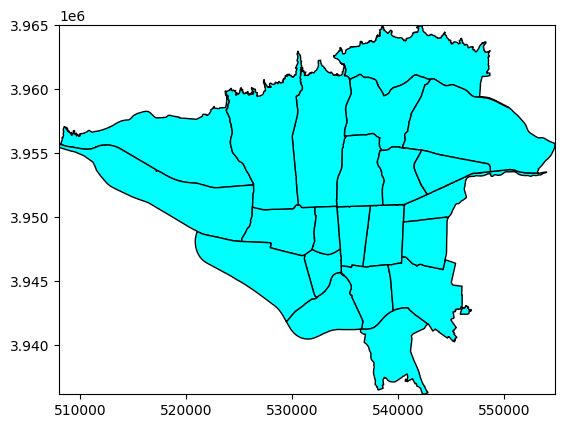

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

for polygon in polygons:
    exterior_coords = list(polygon.exterior.coords)
    interior_coords = list(polygon.interiors[0].coords) if polygon.interiors else []

    if not interior_coords:
        # Simple ring without holes
        ax.add_patch(plt.Polygon(exterior_coords, edgecolor='black', facecolor='aqua'))
    else:
        # Ring with hole
        ax.add_patch(plt.Polygon(exterior_coords, edgecolor='black', facecolor='aqua'))
        ax.add_patch(plt.Polygon(interior_coords, edgecolor='black', facecolor='aqua'))

# Set axis limits
ax.set_xlim(file_Xmin, file_Xmax)
ax.set_ylim(file_Ymin, file_Ymax)

# Show the plot
plt.show()


Create instances of Classes

In [5]:
graph = Graph()
for i, polygon in enumerate(polygons):
    node = Node(polygon, ['#E74C3C','#F1C40F','#3498DB','#F39C12','#9B59B6','#2ECC71'])
    graph.add_vertex(node)

In [6]:
for p1 in graph.vertices:
    for p2 in graph.vertices:
        buffer_distance = 100 # Adjust the buffer distance as needed
        buffer_polygon1 = p1.value.buffer(buffer_distance)
        buffer_polygon2 = p2.value.buffer(buffer_distance)
        if (buffer_polygon1.intersects(buffer_polygon2)) and (p1 != p2):
            graph.add_edge(p1, p2)

Checking Edges Randomly

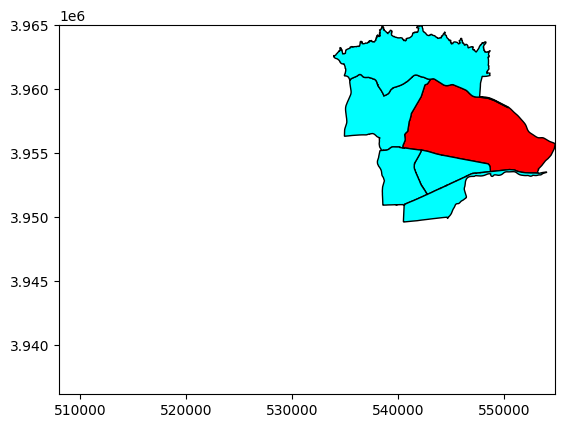

In [7]:
import random
p1 = random.choice(list(graph.vertices))

import matplotlib.pyplot as plt

fig, ax = plt.subplots()


exterior_coords = list(p1.value.exterior.coords)
interior_coords = list(p1.value.interiors[0].coords) if p1.value.interiors else []

if not interior_coords:
    # Simple ring without holes
    ax.add_patch(plt.Polygon(exterior_coords, edgecolor='black', facecolor='red'))
else:
    # Ring with hole
    ax.add_patch(plt.Polygon(exterior_coords, edgecolor='black', facecolor='red'))
    ax.add_patch(plt.Polygon(interior_coords, edgecolor='black', facecolor='red'))

for polygon in list(p1.adj):
    exterior_coords = list(polygon.value.exterior.coords)
    interior_coords = list(polygon.value.interiors[0].coords) if polygon.value.interiors else []

    if not interior_coords:
        # Simple ring without holes
        ax.add_patch(plt.Polygon(exterior_coords, edgecolor='black', facecolor='aqua'))
    else:
        # Ring with hole
        ax.add_patch(plt.Polygon(exterior_coords, edgecolor='black', facecolor='aqua'))
        ax.add_patch(plt.Polygon(interior_coords, edgecolor='black', facecolor='aqua'))

# Set axis limits
ax.set_xlim(file_Xmin, file_Xmax)
ax.set_ylim(file_Ymin, file_Ymax)

# Show the plot
plt.show()


Execute Map Coloring

In [8]:
COLORS = graph.get_color()

RESULT

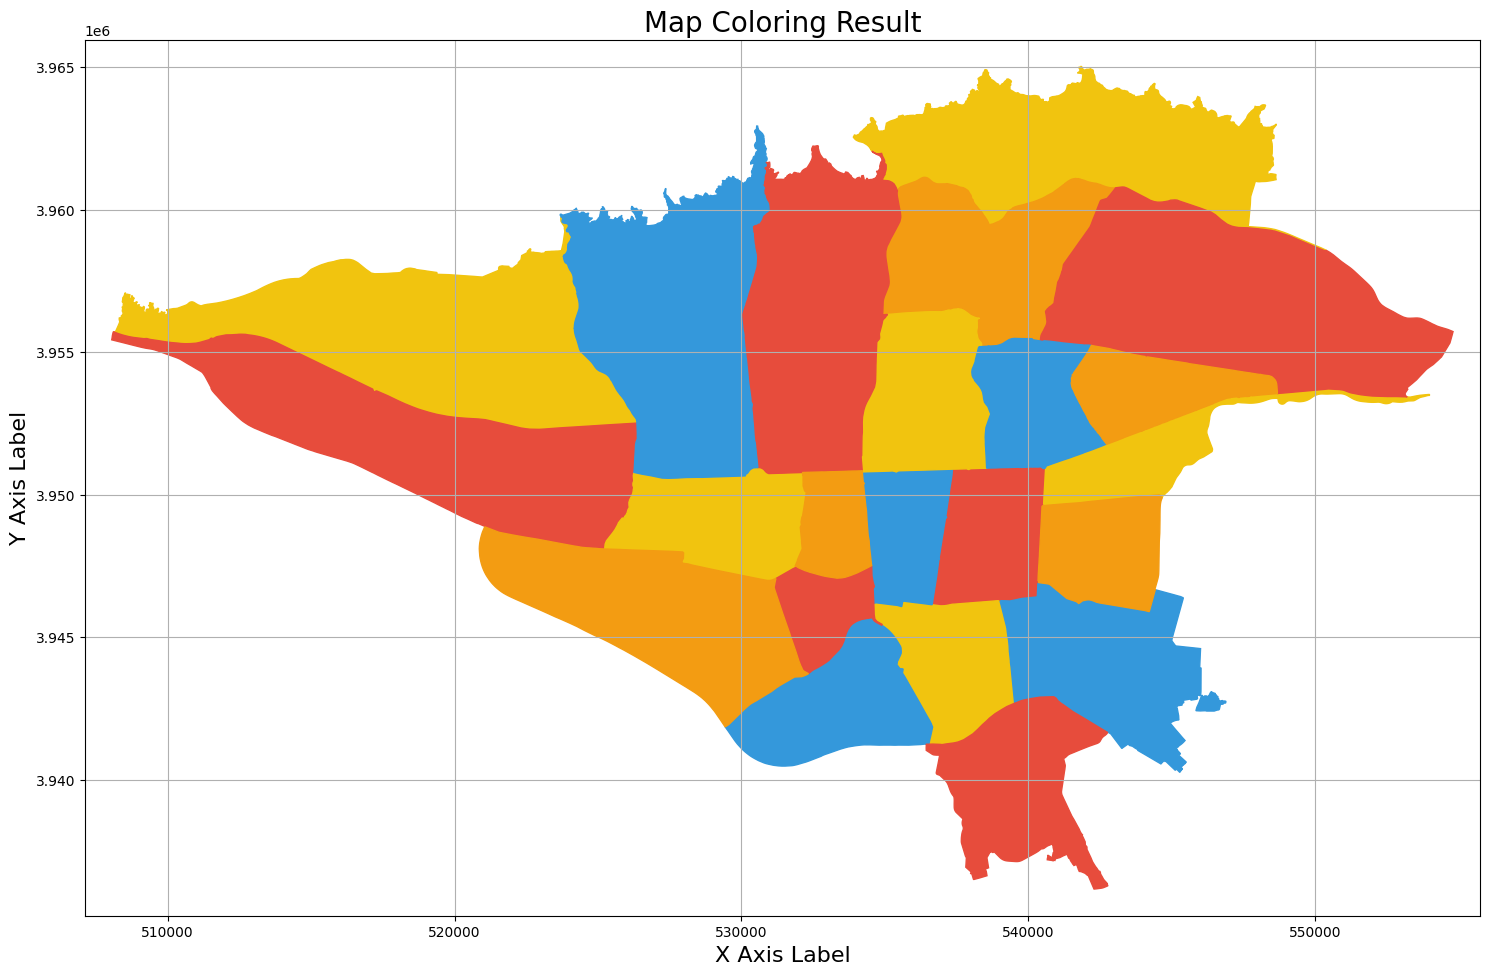

In [9]:
import matplotlib.pyplot as plt

# Adjust the margin for better spacing
margin = (file_Xmax - file_Xmin) * 0.02

# Calculate aspect ratio
aspect_ratio = (file_Xmax + margin - file_Xmin + margin) / (file_Ymax + margin - file_Ymin + margin)

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(18, 18 / aspect_ratio))

# Plot polygons
for polygon in COLORS:
    exterior_coords = list(polygon.value.exterior.coords)
    interior_coords = list(polygon.value.interiors[0].coords) if polygon.value.interiors else []

    if not interior_coords:
        # Simple ring without holes
        ax.add_patch(plt.Polygon(exterior_coords, edgecolor=COLORS[polygon]['color'], facecolor=COLORS[polygon]['color']))
    else:
        # Ring with hole
        ax.add_patch(plt.Polygon(exterior_coords, edgecolor=COLORS[polygon]['color'], facecolor=COLORS[polygon]['color']))
        ax.add_patch(plt.Polygon(interior_coords, edgecolor=COLORS[polygon]['color'], facecolor=COLORS[polygon]['color']))

# Set axis limits
ax.set_xlim(file_Xmin - margin, file_Xmax + margin)
ax.set_ylim(file_Ymin - margin, file_Ymax + margin)

# Add labels and titles
plt.title("Map Coloring Result", fontsize=20)
plt.xlabel("X Axis Label", fontsize=16)
plt.ylabel("Y Axis Label", fontsize=16)


ax.grid(True)

# Show the plot
plt.show()
